# World Data League 2021
## Notebook Template

## External links and resources
Github repo with the data and additional computation: https://github.com/lb4rcella/Sustainable-DTrees-Data/tree/master/Stage_2

## Introduction
We framed the challenge as a classification problem with two main subproblems: 
- identify the type of accident given a set of features
- predict the likelihood of a road to have an accident given its characteristics and the environment conditions

We decided to do this in order to extract from the classification model a profile that would allow us to identify either the most dangerous features of a street (that lead to accidents) or the type of features that lead to a given accident type. 

From these profiles we can derive a set of concrete measures that target the most pressing issues discovered, providing a clear and straightforward solution that can allow for the number of accidents to be reduced, or at least to allocate more resources (ambulances, fire trucks) to the surroundings of the roads that are more likely to have traffic collisions.

### Traffic collision modelling in the literature
Before starting to model the problem, we decided to explore the literature on the subject. However, the works we found leverage on data with features that better describe the accident and its causes than the data we were provided: features such as the number of injuries, number of fatalities, how long the driver had his/her license, if any of the cars had crossed the speed limit and type of vehicles involved. And even if these features weren't present, the datasets simply had samples that had no accidents (these would have been useful to train a classifier to, given the features, predict whether that observation was an accident or not, and from this model derive a profile with the variables that better identify that event).

- https://www.sciencedirect.com/science/article/pii/S2352146518304629
- https://burnstrauma.biomedcentral.com/articles/10.1186/s41038-018-0111-6

## Development

In [1]:
import pandas as pd
import numpy as np
import geopandas

from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier

import collections

In [2]:
df_collisions = geopandas.read_file('../data/Traffic_Collisions/Traffic_Collisions.shp')
df_collisions = df_collisions.drop(['OBJECTID'], axis=1)
df_collisions['ACCIDENTDA'] = pd.to_datetime(df_collisions['ACCIDENTDA'], format="%Y%m%d")
df_collisions = df_collisions.sort_values(by="ACCIDENTDA")

### Initial EDA of the df_collisions dataframe

In [3]:
df_collisions.head()

,ACCIDENTNU,ACCIDENTDA,LOCATION,ACCIDENT_L,IMPACT_LOC,ENVIRONMEN,LIGHT,COLLISION_,TRAFFICCOL,geometry
5467,05-152171,2005-01-01,UNION BLVD @ PARK ST,03-At intersection,01-Within intersection,02-Rain,07-Dark,INTERSECTION,None,MULTIPOINT (-80.51656 43.45680)
9872,06-037684,2005-01-01,CARTIER DR btwn KIMBERLY CRES & KIMBERLY CRES,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,None,MULTIPOINT (-80.49806 43.41914)
5229,05-000584,2005-01-02,ERINBROOK DR @ RITTENHOUSE RD,03-At intersection,01-Within intersection,02-Rain,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.49631 43.40778)
4933,05-000455,2005-01-02,MORGAN AVE @ CENTREVILLE ST,03-At intersection,02-Thru lane,04-Freezing Rain,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.43337 43.42972)
5228,05-000870,2005-01-03,KING ST W @ GREEN ST,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.50977 43.45657)


In [4]:
df_collisions.loc[df_collisions["LOCATION"]=="BLOCK LINE RD @ STRASBURG RD"]["geometry"]

4976    MULTIPOINT (-80.47987 43.41589)
5014    MULTIPOINT (-80.47987 43.41589)
5533    MULTIPOINT (-80.47987 43.41589)
4774    MULTIPOINT (-80.47987 43.41589)
4334    MULTIPOINT (-80.47987 43.41589)
                     ...               
7583    MULTIPOINT (-80.47987 43.41589)
7615    MULTIPOINT (-80.47987 43.41589)
7616    MULTIPOINT (-80.47987 43.41589)
5681    MULTIPOINT (-80.47987 43.41589)
7638    MULTIPOINT (-80.47987 43.41589)
Name: geometry, Length: 120, dtype: geometry

In [5]:
df_collisions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 12201 entries, 5467 to 12058
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ACCIDENTNU  12201 non-null  object        
 1   ACCIDENTDA  12201 non-null  datetime64[ns]
 2   LOCATION    12201 non-null  object        
 3   ACCIDENT_L  12186 non-null  object        
 4   IMPACT_LOC  12165 non-null  object        
 5   ENVIRONMEN  12147 non-null  object        
 6   LIGHT       12094 non-null  object        
 7   COLLISION_  12201 non-null  object        
 8   TRAFFICCOL  0 non-null      object        
 9   geometry    12201 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1), object(8)
memory usage: 1.0+ MB


In [6]:
# trafficcol is null, we can drop it
df_collisions = df_collisions.drop(["TRAFFICCOL"], axis=1)

In [7]:
# Road segments sorted by number of accidents
df_collisions["LOCATION"].value_counts().head(20)

BLOCK LINE RD @ STRASBURG RD                    120
GLASGOW ST @ BELMONT AVE W                       84
BELMONT AVE W @ GAGE AVE                         83
RIVER RD E @ LORRAINE AVE                        78
WILSON AVE @ KINGSWAY DR                         76
KING ST E @ QUEEN ST N                           75
CEDAR ST N @ KING ST E / CEDAR ST S              73
KING ST W @ ONTARIO ST S / ONTARIO ST N          68
FRANKLIN ST S @ KINGSWAY DR                      68
WILSON AVE @ FAIRWAY RD S                        67
WABANAKI DR @ WILSON AVE                         66
STIRLING AVE S @ KING ST E / STIRLING AVE N      66
BORDEN AVE N @ KING ST E / BORDEN AVE S          66
GLASGOW ST @ PARK ST                             64
HOMER WATSON BLVD @ HOFFMAN ST                   63
QUEENS BLVD @ BELMONT AVE W / BELMONT AVE E      62
RIVER RD E @ HOLBORN DR                          59
WELLINGTON ST N @ SHIRLEY AVE / RIVERBEND DR     59
STIRLING AVE S @ MILL ST                         58
UNION BLVD @

In [8]:
# Location where the accident took place
df_collisions["ACCIDENT_L"].value_counts()

04-At/near private drive    3492
01-Non intersection         3274
03-At intersection          3050
02-Intersection related     2162
99-Other                      92
10-Parking lot                37
98-Other                      26
05-At railway crossing        24
06-Underpass or tunnel        14
07-Overpass or bridge         13
08-Trail                       2
Name: ACCIDENT_L, dtype: int64

In [9]:
# More specific, inside accident_location
df_collisions["IMPACT_LOC"].value_counts()

02-Thru lane                      7091
01-Within intersection            2545
11-Not on roadway - right side     747
09-Right shoulder                  636
12-Off highway                     297
10-Not on roadway - left side      295
03-Left turn lane                  202
04-Right turn lane                 149
99-Other                           106
08-Left shoulder                    74
05-Right turn channel               12
07-Passing lane                      8
06-Two-way left turn lane            3
Name: IMPACT_LOC, dtype: int64

In [10]:
# Data about the weather when the collision happened
df_collisions["ENVIRONMEN"].value_counts()

01-Clear                     9350
03-Snow                      1343
02-Rain                      1115
04-Freezing Rain              125
07-Fog, mist, smoke, dust      68
05-Drifting Snow               54
06-Strong wind                 47
99-Other                       45
Name: ENVIRONMEN, dtype: int64

In [11]:
# Lighting conditions when the collision happened
df_collisions["LIGHT"].value_counts()

01-Daylight                8781
08-Dark, artificial        1562
07-Dark                    1112
05-Dusk                     286
06-Dusk, artificial         119
03-Dawn                     105
02-Daylight, artificial      59
04-Dawn, artificial          52
99-Other                     18
Name: LIGHT, dtype: int64

### Check most common accident location for each of the two collision types

In [12]:
df_collisions.loc[df_collisions["COLLISION_"]=="MIDBLOCK"]

,ACCIDENTNU,ACCIDENTDA,LOCATION,ACCIDENT_L,IMPACT_LOC,ENVIRONMEN,LIGHT,COLLISION_,geometry
9872,06-037684,2005-01-01,CARTIER DR btwn KIMBERLY CRES & KIMBERLY CRES,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,MULTIPOINT (-80.49806 43.41914)
9689,05-000952,2005-01-03,GREENFIELD AVE btwn TRAYNOR AVE & KINGSWAY DR,04-At/near private drive,02-Thru lane,01-Clear,"08-Dark, artificial",MIDBLOCK,MULTIPOINT (-80.44359 43.42511)
9864,05-001288,2005-01-04,STRASBURG RD btwn OTTAWA ST S & KINGSWOOD DR,01-Non intersection,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,MULTIPOINT (-80.48659 43.42193)
9816,05-001097,2005-01-04,KINGSWAY DR btwn GREENFIELD AVE & WILSON AVE,01-Non intersection,02-Thru lane,01-Clear,07-Dark,MIDBLOCK,MULTIPOINT (-80.44242 43.42340)
9671,05-001306,2005-01-04,OVERLEA DR btwn KELLY DR & EAGEN DR,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,MULTIPOINT (-80.51962 43.43239)
...,...,...,...,...,...,...,...,...,...
12043,18-038440,2018-02-17,HARVEST CRT btwn HARVEST CRT & HARVEST CRT,01-Non intersection,02-Thru lane,01-Clear,"08-Dark, artificial",MIDBLOCK,MULTIPOINT (-80.44236 43.39161)
12014,18-037960,2018-02-17,MORGAN AVE btwn SOUTHILL DR & PEPPERWOOD CRES,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,MULTIPOINT (-80.42761 43.42817)
12020,18-042256,2018-02-21,CHESTNUT ST btwn LUELLA ST & MANSION ST,01-Non intersection,09-Right shoulder,01-Clear,07-Dark,MIDBLOCK,MULTIPOINT (-80.47992 43.45754)
11997,18-042164,2018-02-21,AVON RD btwn FREDERICK ST & APPLEWOOD AVE,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,MULTIPOINT (-80.45772 43.46419)


In [13]:
df_collisions.loc[df_collisions["COLLISION_"]=="INTERSECTION"]["ACCIDENT_L"].value_counts()

03-At intersection          3043
02-Intersection related     2143
01-Non intersection         1449
04-At/near private drive    1062
99-Other                      30
10-Parking lot                16
98-Other                      11
05-At railway crossing         9
06-Underpass or tunnel         8
07-Overpass or bridge          7
08-Trail                       2
Name: ACCIDENT_L, dtype: int64

In [14]:
df_collisions.loc[df_collisions["COLLISION_"]=="MIDBLOCK"]["ACCIDENT_L"].value_counts()

04-At/near private drive    2430
01-Non intersection         1825
99-Other                      62
10-Parking lot                21
02-Intersection related       19
98-Other                      15
05-At railway crossing        15
03-At intersection             7
06-Underpass or tunnel         6
07-Overpass or bridge          6
Name: ACCIDENT_L, dtype: int64

In [15]:
df_collisions.loc[df_collisions["COLLISION_"]=="INTERSECTION"]["IMPACT_LOC"].value_counts()

02-Thru lane                      3961
01-Within intersection            2518
11-Not on roadway - right side     427
09-Right shoulder                  219
03-Left turn lane                  157
10-Not on roadway - left side      146
04-Right turn lane                 118
12-Off highway                     109
99-Other                            55
08-Left shoulder                    37
05-Right turn channel               11
07-Passing lane                      4
06-Two-way left turn lane            2
Name: IMPACT_LOC, dtype: int64

In [16]:
df_collisions.loc[df_collisions["COLLISION_"]=="MIDBLOCK"]["IMPACT_LOC"].value_counts()

02-Thru lane                      3130
09-Right shoulder                  417
11-Not on roadway - right side     320
12-Off highway                     188
10-Not on roadway - left side      149
99-Other                            51
03-Left turn lane                   45
08-Left shoulder                    37
04-Right turn lane                  31
01-Within intersection              27
07-Passing lane                      4
06-Two-way left turn lane            1
05-Right turn channel                1
Name: IMPACT_LOC, dtype: int64

### Include week_day and month as features to study the number of accidents for the two

In [17]:
df_collisions["week_day"] = df_collisions["ACCIDENTDA"].dt.weekday
df_collisions["month"] = df_collisions["ACCIDENTDA"].dt.month
df_collisions["year"] = df_collisions["ACCIDENTDA"].dt.year

In [18]:
df_collisions.groupby(["year", "COLLISION_"]).count().sort_values("year", ascending=True)["ACCIDENTNU"]

year  COLLISION_  
2005  INTERSECTION    768
      MIDBLOCK        368
2006  INTERSECTION    729
      MIDBLOCK        347
2007  INTERSECTION    778
      MIDBLOCK        344
2008  INTERSECTION    817
      MIDBLOCK        308
2009  INTERSECTION    693
      MIDBLOCK        199
2010  INTERSECTION    657
      MIDBLOCK        198
2011  MIDBLOCK        179
      INTERSECTION    563
2012  INTERSECTION    429
      MIDBLOCK        103
2013  INTERSECTION    393
      MIDBLOCK        320
2014  INTERSECTION    564
      MIDBLOCK        481
2015  INTERSECTION    485
      MIDBLOCK        527
2016  INTERSECTION    460
      MIDBLOCK        489
2017  INTERSECTION    403
      MIDBLOCK        461
2018  INTERSECTION     53
      MIDBLOCK         85
Name: ACCIDENTNU, dtype: int64

We can see that on the initial years there were way more INTERSECTION accidents than MIDBLOCK. This can impact our analysis later on.

In [19]:
df_collisions.groupby("year").count().sort_values("ACCIDENTDA", ascending=False)["ACCIDENTNU"]

year
2005    1136
2008    1125
2007    1122
2006    1076
2014    1045
2015    1012
2016     949
2009     892
2017     864
2010     855
2011     742
2013     713
2012     532
2018     138
Name: ACCIDENTNU, dtype: int64

In [20]:
df_collisions.groupby("month").count().sort_values("ACCIDENTDA", ascending=False)["ACCIDENTNU"]

month
2     1376
12    1279
1     1250
11    1159
10    1035
3     1000
5      906
9      906
7      878
6      843
8      791
4      778
Name: ACCIDENTNU, dtype: int64

In [21]:
df_collisions.groupby("week_day").count().sort_values("ACCIDENTDA", ascending=False)["ACCIDENTNU"]

week_day
4    2104
1    1859
3    1841
2    1806
0    1727
5    1646
6    1218
Name: ACCIDENTNU, dtype: int64

#### Some interesting take-aways can be highlighted:
- As expected, we observe the late autumn and winter months to be the ones with more accidents (possibly due to the worse driving conditions, with rain or snow)
- Concerning the week days, we see that thursday (day 4) is the day with more accidents, followed by monday, wednesday and tuesday (all with similar values). On the opposite side, saturday and sunday are the days with less accidents (especially sunday, where less people work and more tend to stay at home and spend a more relaxed day)

## Aditional datasets used

Thanks to the data availability on the city of Waterloo open data platform (https://data.waterloo.ca), we assessed several data sets in order to enrich our original one. The datasets we analysed were:
- Traffic volume
- Traffic markings 
- Traffic signs
- Road intersection
- Road characteristics

From the ones we analysed, the roads dataset (https://data.waterloo.ca/datasets/KitchenerGIS::roads?geometry=-81.124%2C43.340%2C-79.817%2C43.514) seemed to have many features that we could incorporate, in order to improve the quality of the data. We also included the others mentioned, but only for the second problem.

The original roads dataset has 70 features detailed for several roads of the City of Kitchener, more specifically for 5936 roads. We decided to only focus on 15 of those features, since they seemed the most relevant for our task, according to their description in the dataset's website.

One of our concerns of aggregating multiple data sources was not to manipulate results with data leakage. As a result, we just used the numerical features of the original roads dataset and calculated the average of those features for all locations that are suitable for each observation.

In [22]:
df_roads = pd.read_csv('../data/road_data_filtered.csv', index_col = 0)

In [23]:
df_roads.head()

,STREET,LANES,CATEGORY,SUBCATEGORY,PAVEMENT_WIDTH,ROW_WIDTH,SHOULDER,FLOW_DIRECTION,SURFACE_LAYER_TYPE,OFFICIAL_ROAD_CLASSIFICATION,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,SERVICE_YEAR,Shape__Length
0,FAIRWAY RD N,4,ROAD,MAJOR,15.0,51.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,NaN,171.547722
1,BLACK WALNUT DR,2,ROAD,MINOR,10.0,26.0,PAVED,TwoWay,PAVED,4,50,NO ACCESS,Y,1976.0,153.433200
2,BECHTEL DR,2,ROAD,MINOR,10.0,26.0,PAVED,TwoWay,PAVED,4,40,NO ACCESS,Y,1971.0,320.105477
3,ANVIL ST,2,ROAD,LOCAL,9.0,20.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,1980.0,101.994934
4,EBY ST S,2,ROAD,LOCAL,7.0,12.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,2005.0,34.417292


To merge our original data with this dataset, we had to first pre-process the location names in the collisions dataset. We had to do this because the accident location in the original data is outlined has an intersection or a midblock of a street, while the roads data is organized on street level.

To do so we split the intersection locations into two datapoints, one with the name of the first street in the location value and the other one with the second street name. For the midblock locations we discarded the information describing the segment of the street were the accident occured, and considered only the street name.

The resulting dataset has 21148 rows and 24 features.

In [24]:
df_final = pd.read_csv("../data/collisions_road_level_final.csv")
df_final.head()

,LOCATION,ACCIDENT_LOCATION,IMPACT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,COLLISION_TYPE,DAY_OF_WEEK,MONTH,IS_WEEKEND,STREET,...,ROW_WIDTH,SHOULDER,FLOW_DIRECTION,SURFACE_LAYER_TYPE,OFFICIAL_ROAD_CLASSIFICATION,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,SERVICE_YEAR,Shape__Length
0,RIVER RD E,01-Non intersection,02-Thru lane,01-Clear,"08-Dark, artificial",MIDBLOCK,Monday,January,0,RIVER RD E,...,7.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,1981.0,128.050597
1,RIVER RD E,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,Saturday,March,1,RIVER RD E,...,7.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,1981.0,128.050597
2,RIVER RD E,01-Non intersection,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,Tuesday,April,0,RIVER RD E,...,7.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,1981.0,128.050597
3,RIVER RD E,01-Non intersection,02-Thru lane,02-Rain,"08-Dark, artificial",MIDBLOCK,Monday,December,0,RIVER RD E,...,7.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,1981.0,128.050597
4,RIVER RD E,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,MIDBLOCK,Saturday,June,1,RIVER RD E,...,7.0,PAVED,TwoWay,PAVED,6,50,NO ACCESS,N,1981.0,128.050597


## Collision location likelihood prediction

The goal of this challenge is to better understand the underlying causes that lead to traffic accidents in a modern city like Kitchener. By identifying those causes, city and regional entities may be able to improve the safety of the roads or the response times of emergency teams when an accident occurs.

In order to study such causes in the city of Kitchener, we decided to build a classification model that could identify the street were an accident would most likely occur based on a set of key features. By leveraging such model, we were then able to point out which of those key features had more relevance in the street's identification.

Due to the predominance of categorical features on the dataset, catboost algorithm was a straightforward choice for all of us. Catboost is a gradient boosting framework optimised to deal with categorical variables.

Since our model's target is the name of a street, the target variable for our dataset is then the LOCATION.

In [25]:
yy_array = df_final['LOCATION'].to_numpy()

To train the classifier we decided to discard certain variables, such as the COLLISION_TYPE and the IMPACT_LOCATION, since they could bias the training due to their correlation with our target variable (LOCATION). 

In [26]:
xx_array = df_final.drop(['COLLISION_TYPE', 'LOCATION', 'IMPACT_LOCATION', 'ACCIDENT_LOCATION', 'STREET', 'OFFICIAL_ROAD_CLASSIFICATION', 'SERVICE_YEAR'], axis=1).to_numpy()

Remove streets where only one 1 accident occured.

In [27]:
less_than_2 = [i for i in collections.Counter(yy_array) if collections.Counter(yy_array)[i] < 2]
index_to_remove = np.where(np.isin(yy_array, less_than_2))

mask = np.ones(yy_array.size, dtype=bool)
mask[index_to_remove] = False
yy_array_filtered = yy_array[mask]
xx_array_filtered = xx_array[mask]

all_locations = sorted(list(set(yy_array_filtered)))
yy_array_mapped = list()
for i in yy_array_filtered:
    yy_array_mapped.append(all_locations.index(i))

In [28]:
# define categorical features
cat_features = [0, 1, 2, 3, 6, 7, 10, 11, 12, 14, 15]

# split data
xx_train, xx_test, yy_train, yy_test = train_test_split(xx_array_filtered, yy_array_mapped, test_size=0.2, random_state = 42, stratify=yy_array_mapped)

Instantiate and fit the CatBoost classifier

In [29]:
model = CatBoostClassifier(
    iterations=100,
    random_strength=0.1,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    task_type='GPU'
)

model.fit(X=xx_train, y=yy_train, cat_features=cat_features, verbose=1)

Learning rate set to 0.5
0:	learn: 0.1899597	total: 4.84s	remaining: 7m 58s
1:	learn: 0.1205548	total: 9.17s	remaining: 7m 29s
2:	learn: 0.1359056	total: 13.7s	remaining: 7m 22s
3:	learn: 0.1515529	total: 18.7s	remaining: 7m 28s
4:	learn: 0.1663703	total: 22.3s	remaining: 7m 4s
5:	learn: 0.2565789	total: 27.1s	remaining: 7m 4s
6:	learn: 0.2989569	total: 32.3s	remaining: 7m 9s
7:	learn: 0.3151968	total: 37.4s	remaining: 7m 10s
8:	learn: 0.3355263	total: 43.2s	remaining: 7m 16s
9:	learn: 0.3975818	total: 47.3s	remaining: 7m 5s
10:	learn: 0.4372333	total: 51.9s	remaining: 6m 59s
11:	learn: 0.4736842	total: 56.8s	remaining: 6m 56s
12:	learn: 0.4909317	total: 1m 1s	remaining: 6m 54s
13:	learn: 0.4996444	total: 1m 7s	remaining: 6m 52s
14:	learn: 0.5318279	total: 1m 11s	remaining: 6m 44s
15:	learn: 0.5435040	total: 1m 16s	remaining: 6m 39s
16:	learn: 0.5523945	total: 1m 21s	remaining: 6m 36s
17:	learn: 0.5691679	total: 1m 25s	remaining: 6m 31s
18:	learn: 0.5874229	total: 1m 30s	remaining: 6m 

In [30]:
prob_pred = model.predict_proba(xx_test)

pred = list()
for i in range(len(prob_pred)):
    pred.append(np.argmax(prob_pred[i]))

In [31]:
accuracy_score(yy_test, pred)

0.7217350082958047

The achieved result is already satisfying, but in order to improve our solution we can consider the top 5 predictions of the algorithm instead of the top 1. With a limited number of resources, it would be feasible to allocate them and we can be much more confident about where the accident can take place (with the obvious 5 places uncertainty)

In [32]:
for each_top in range(1, 11):
    values_corrected = 0
    for i in range(len(prob_pred)):
            
        top_idx = np.argsort(prob_pred[i])[-each_top:]

        if yy_test[i] in top_idx:
            values_corrected += 1

    print(f"TOP {each_top} ACC", values_corrected/len(prob_pred))

TOP 1 ACC 0.7217350082958047
TOP 2 ACC 0.80943351505096
TOP 3 ACC 0.8542308603934582
TOP 4 ACC 0.8769850675515525
TOP 5 ACC 0.8919175159990519
TOP 6 ACC 0.9059018724816307
TOP 7 ACC 0.9182270680255985
TOP 8 ACC 0.9284190566484949
TOP 9 ACC 0.9345816544204788
TOP 10 ACC 0.9395591372363119


In [36]:
list_columns = df_final.drop(['COLLISION_TYPE', 'LOCATION', 'IMPACT_LOCATION', 'ACCIDENT_LOCATION', 'STREET', 'OFFICIAL_ROAD_CLASSIFICATION', 'SERVICE_YEAR'], axis=1).columns
range_columns = list(range(len(list_columns)))

for idx, col in zip(range_columns, list_columns):
    print("FEATURE", idx, "->", col)

FEATURE 0 -> ENVIRONMENT_CONDITION
FEATURE 1 -> LIGHT
FEATURE 2 -> DAY_OF_WEEK
FEATURE 3 -> MONTH
FEATURE 4 -> IS_WEEKEND
FEATURE 5 -> LANES
FEATURE 6 -> CATEGORY
FEATURE 7 -> SUBCATEGORY
FEATURE 8 -> PAVEMENT_WIDTH
FEATURE 9 -> ROW_WIDTH
FEATURE 10 -> SHOULDER
FEATURE 11 -> FLOW_DIRECTION
FEATURE 12 -> SURFACE_LAYER_TYPE
FEATURE 13 -> SPEED_LIMIT_KM
FEATURE 14 -> TRUCK_ACCESS
FEATURE 15 -> BUS_ROUTE
FEATURE 16 -> Shape__Length


In [37]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(xx_train, yy_train, cat_features=cat_features))

Creating legend with loc="best" can be slow with large amounts of data.


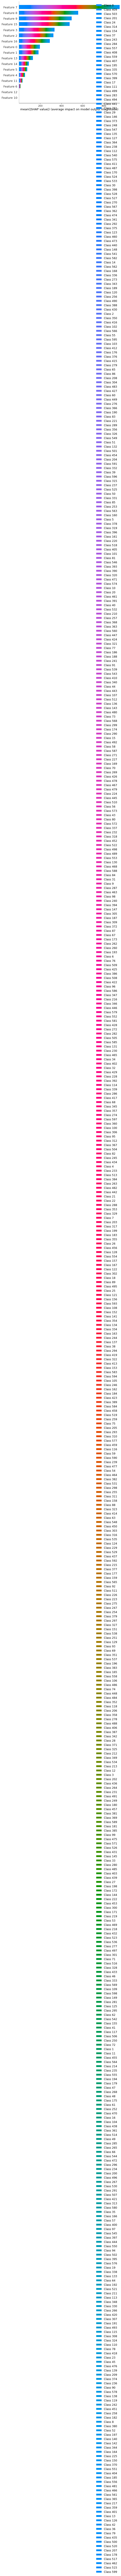

In [38]:
shap.summary_plot(shap_values, xx_train)

### Results analysis 

The shap values are based on the Shapley values (game theory) and allow us to quantify the contribution that each feature brings to the prediction made by the model. This type of analysis is useful since the CatBoost model has the problem of not being as easy to interpret as a Random Forest (for example).

The interpretation of the shap values in order to extract the feature importance for each class is not as simple as it is on the 2nd classification task, however it is also not as relevant due to the granularity of this classification problem (>600 streets). Nonetheless we can understand the variables that hint into a bigger likelihood of a street to have a car collision. From the plot above, these are:
- street subcategory: classification of a street according to its characteristics (major, minor, local, lane). Note that there are no highway accidents on this dataset
- pavement width: road pavement width
- row width: the width of each row of the street
- bus route: information about the presence of a bus route on the street

Concerning the subcategory it's difficult to propose specific measures, since this classification framework is not controlled by us. However it helps us understand that different road category have different types of traffic collisions.

The remaining 3 allow us to focus our analysis on these to come up with specific measures to target the problem, such as increasing/decreasing the width of the rows (maybe reducing the number of lanes to do so) and replanning the bus routes in a better way.

The big advantage of this model is that it provides us a likelihood "map" of the city streets that can be used for better street patrolling and resource planning. It is also fairly easy to extrapolate to other streets, under the assumption of data availability.

## Collision type classification

The second analysis we considered relevant was to understand the patterns that can help us distinguish the two main collision types present of the dataset, allowing us to profile them in a better way.

In [39]:
col_type_data = pd.read_csv("../data/collision_type_dataset_road_level_final.csv")
col_type_data['ACCIDENTDA'] = pd.to_datetime(col_type_data['ACCIDENTDA'], format='%Y-%m-%d')

In [40]:
col_type_data['DAY_OF_WEEK'] = col_type_data['ACCIDENTDA'].dt.day_name()
col_type_data['MONTH'] = col_type_data['ACCIDENTDA'].dt.month
col_type_data['YEAR'] = col_type_data['ACCIDENTDA'].dt.year
col_type_data['DAY'] = col_type_data['ACCIDENTDA'].dt.day
col_type_data['SEASON'] = col_type_data['ACCIDENTDA'].dt.month%12 // 3 + 1

In [41]:
col_type_data.head()

,ACCIDENTNU,ACCIDENTDA,ACCIDENT_L,IMPACT_LOC,COLLISION_,ENVIRONMEN,LIGHT,geo,N_SIGNS,TRAFFIC_VOLUME,...,avg_pav_with,avg_row_width,avg_off_class,avg_speed_limit,avg_shape_length,DAY_OF_WEEK,MONTH,YEAR,DAY,SEASON
0,05-152171,2005-01-01,03-At intersection,01-Within intersection,INTERSECTION,02-Rain,07-Dark,MULTIPOINT (-80.51655643793821 43.4567952246049),1,0.0,...,238.0,505.0,134,1200,3176.901787,Saturday,1,2005,1,1
1,06-037684,2005-01-01,04-At/near private drive,02-Thru lane,MIDBLOCK,01-Clear,01-Daylight,MULTIPOINT (-80.4980630163728 43.4191423078746),0,0.0,...,35.0,75.0,24,200,847.845042,Saturday,1,2005,1,1
2,05-000584,2005-01-02,03-At intersection,01-Within intersection,INTERSECTION,02-Rain,01-Daylight,MULTIPOINT (-80.4963066588839 43.4077802830626),0,0.0,...,442.0,842.0,153,1990,4376.289814,Sunday,1,2005,2,1
3,05-000455,2005-01-02,03-At intersection,02-Thru lane,INTERSECTION,04-Freezing Rain,01-Daylight,MULTIPOINT (-80.43336555253759 43.4297180667495),0,0.0,...,90.0,196.0,60,500,1506.309460,Sunday,1,2005,2,1
4,05-000870,2005-01-03,04-At/near private drive,02-Thru lane,INTERSECTION,01-Clear,01-Daylight,MULTIPOINT (-80.509765542994 43.4565745307324),8,24794.0,...,202.0,348.0,97,850,2508.061494,Monday,1,2005,3,1


In [42]:
col_type_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12045 entries, 0 to 12044
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ACCIDENTNU                12045 non-null  object        
 1   ACCIDENTDA                12045 non-null  datetime64[ns]
 2   ACCIDENT_L                12045 non-null  object        
 3   IMPACT_LOC                12045 non-null  object        
 4   COLLISION_                12045 non-null  object        
 5   ENVIRONMEN                12045 non-null  object        
 6   LIGHT                     12045 non-null  object        
 7   geo                       12045 non-null  object        
 8   N_SIGNS                   12045 non-null  int64         
 9   TRAFFIC_VOLUME            12045 non-null  float64       
 10  ADVANCE CROSSING MARKING  12045 non-null  int64         
 11  BIKE BOX                  12045 non-null  int64         
 12  BIKE/EDGE LINE    

In [43]:
col_type_data["TURNING ARROW"].value_counts()

0     2294
5      548
1      535
12     514
3      397
      ... 
96       8
71       6
73       3
48       2
64       2
Name: TURNING ARROW, Length: 82, dtype: int64

In [44]:
# drop accident related features
yy_array = col_type_data['COLLISION_'].to_numpy()
xx_array = col_type_data.drop(['ACCIDENTNU', 'ACCIDENTDA', 'ACCIDENT_L', 'IMPACT_LOC', 'COLLISION_', 'LANE DIVIDER', 'geo'], axis=1).to_numpy()
col_type_data.drop(['ACCIDENTNU', 'ACCIDENTDA', 'ACCIDENT_L', 'IMPACT_LOC', 'COLLISION_', 'LANE DIVIDER', 'geo'], axis=1).columns

Index(['ENVIRONMEN', 'LIGHT', 'N_SIGNS', 'TRAFFIC_VOLUME',
       'ADVANCE CROSSING MARKING', 'BIKE BOX', 'BIKE/EDGE LINE', 'CENTRE LINE',
       'CROSSWALK LINE', 'GREEN SHARED-USE', 'RR TRACK STOP LINE',
       'SCHOOL CROSSWALK LINE', 'SHARROW', 'SPEED HUMP', 'STOP LINE',
       'TRAIL CROSSING', 'TURNING ARROW', 'TWO WAY LEFT TURN', 'YIELD LINE',
       'TOTAL_MARKINGS', 'avg_lanes', 'avg_pav_with', 'avg_row_width',
       'avg_off_class', 'avg_speed_limit', 'avg_shape_length', 'DAY_OF_WEEK',
       'MONTH', 'YEAR', 'DAY', 'SEASON'],
      dtype='object')

In [45]:
xx_array[0,:]

array(['02-Rain', '07-Dark', 1, 0.0, 2, 0, 0, 36, 3, 0, 2, 0, 4, 0, 61, 0,
       50, 0, 0, 182, 68, 238.0, 505.0, 134, 1200, 3176.9017866941394,
       'Saturday', 1, 2005, 1, 1], dtype=object)

In [46]:
yy_array_bin = [0 if i == 'INTERSECTION' else 1 for i in yy_array]
cat_features = [0, 1, 26, 30]

xx_train, xx_test, yy_train, yy_test = train_test_split(xx_array, yy_array_bin, test_size=0.2, random_state = 42, stratify = yy_array_bin)

In [47]:
xx_train[0]

array(['01-Clear', '02-Daylight, artificial', 9, 45744.0, 2, 0, 39, 62,
       24, 0, 1, 2, 0, 24, 73, 0, 60, 0, 11, 359, 256, 981.0, 2427.0, 392,
       3720, 15344.235134270915, 'Tuesday', 7, 2008, 8, 3], dtype=object)

In [48]:
# train catboost
model = CatBoostClassifier(iterations=100)
model.fit(xx_train, yy_train, cat_features)

preds_class = model.predict(xx_test)

Learning rate set to 0.223902
0:	learn: 0.6525722	total: 31.8ms	remaining: 3.15s
1:	learn: 0.6175215	total: 64.7ms	remaining: 3.17s
2:	learn: 0.5968867	total: 111ms	remaining: 3.6s
3:	learn: 0.5879798	total: 157ms	remaining: 3.76s
4:	learn: 0.5652534	total: 188ms	remaining: 3.58s
5:	learn: 0.5531739	total: 207ms	remaining: 3.24s
6:	learn: 0.5399034	total: 227ms	remaining: 3.01s
7:	learn: 0.5246440	total: 252ms	remaining: 2.9s
8:	learn: 0.5189374	total: 278ms	remaining: 2.81s
9:	learn: 0.5120953	total: 313ms	remaining: 2.81s
10:	learn: 0.5097519	total: 345ms	remaining: 2.79s
11:	learn: 0.5030300	total: 379ms	remaining: 2.78s
12:	learn: 0.4935605	total: 425ms	remaining: 2.84s
13:	learn: 0.4915156	total: 445ms	remaining: 2.73s
14:	learn: 0.4854706	total: 467ms	remaining: 2.65s
15:	learn: 0.4768458	total: 489ms	remaining: 2.57s
16:	learn: 0.4649220	total: 511ms	remaining: 2.5s
17:	learn: 0.4619078	total: 532ms	remaining: 2.42s
18:	learn: 0.4572216	total: 595ms	remaining: 2.54s
19:	learn: 0

In [49]:
from sklearn.metrics import accuracy_score

accuracy_score(preds_class, yy_test)

0.9036944790369448

In [50]:
yy_train[:10]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [51]:
from sklearn.metrics import confusion_matrix

confusion_matrix(preds_class, yy_test)

array([[1436,  131],
       [ 101,  741]], dtype=int64)

In [52]:
import shap
shap.initjs()

In [53]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(xx_train, yy_train, cat_features=cat_features))

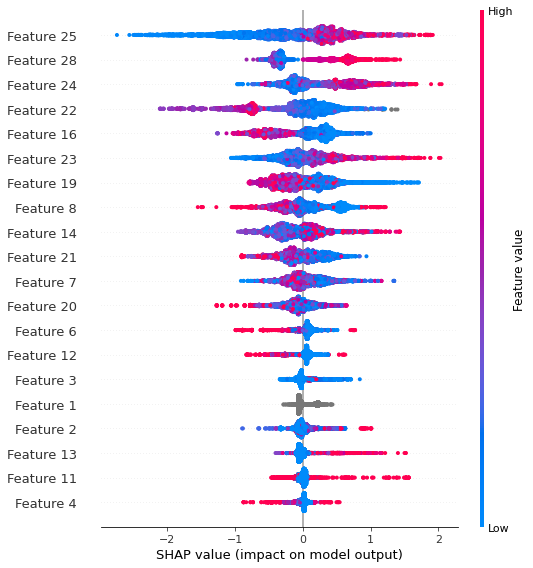

In [54]:
shap.summary_plot(shap_values, xx_train)

In [55]:
list_columns = col_type_data.drop(['ACCIDENTNU', 'ACCIDENTDA', 'ACCIDENT_L', 'IMPACT_LOC', 'COLLISION_', 'LANE DIVIDER', 'geo'], axis=1).columns
range_columns = list(range(len(list_columns)))

for idx, col in zip(range_columns, list_columns):
    print("FEATURE", idx, "->", col)

FEATURE 0 -> ENVIRONMEN
FEATURE 1 -> LIGHT
FEATURE 2 -> N_SIGNS
FEATURE 3 -> TRAFFIC_VOLUME
FEATURE 4 -> ADVANCE CROSSING MARKING
FEATURE 5 -> BIKE BOX
FEATURE 6 -> BIKE/EDGE LINE
FEATURE 7 -> CENTRE LINE
FEATURE 8 -> CROSSWALK LINE
FEATURE 9 -> GREEN SHARED-USE
FEATURE 10 -> RR TRACK STOP LINE
FEATURE 11 -> SCHOOL CROSSWALK LINE
FEATURE 12 -> SHARROW
FEATURE 13 -> SPEED HUMP
FEATURE 14 -> STOP LINE
FEATURE 15 -> TRAIL CROSSING
FEATURE 16 -> TURNING ARROW
FEATURE 17 -> TWO WAY LEFT TURN
FEATURE 18 -> YIELD LINE
FEATURE 19 -> TOTAL_MARKINGS
FEATURE 20 -> avg_lanes
FEATURE 21 -> avg_pav_with
FEATURE 22 -> avg_row_width
FEATURE 23 -> avg_off_class
FEATURE 24 -> avg_speed_limit
FEATURE 25 -> avg_shape_length
FEATURE 26 -> DAY_OF_WEEK
FEATURE 27 -> MONTH
FEATURE 28 -> YEAR
FEATURE 29 -> DAY
FEATURE 30 -> SEASON


### Results analysis 

From the interpretation of the shap values we can highlight a set of features that are more relevant for the model:
- avg_shape_length: length of the street
- YEAR: happens thanks to the phenomena discussed above, where for the initial years the classes were highly unbalanced
- avg_speed_limit: the average speed limit of the street
- avg_row_width: the width of each row on that street

We know that when the impact is negative that variable is influencing class 0 (INTERSECTION), while when it is positive it's influencing class 1 (MIDBLOCK). This "impact" value can be seen on the x axis of the shap values plot.
While avg_shape_length and YEAR are positively correlated with our target variable (the bigger the road and the later in time the accident took place, the more likely it is for it to be MIDBLOCK), the remaining two highlighted are negatively correlated: the smaller they are the more likely it is for the collision type to be MIDBLOCK.

From these we can derive a set of characteristics and suggestions:
- The **narrower the street** the **more likely it is for the collision to be midblock** (maybe due to the cars having less space to overtake or to pass by one another). It would be good to standardize the row_width based on the streets with less accidents, and in this way the number of accidents could possibly be reduced.
- Same goes for the speed limit, the number of MIDBLOCK collisions increase with it and with the length of the street. Logically, longer streets with higher speed limit tend to be more dangerous and to have more accidents, so a good solution would be to include more speed humps or traffic lights along the way (in places where people may need to cross the street, for example). In this way not only the number of traffic collisions is reduced, but the accessibility is increased.
- The YEAR correlation is the less interesting one to analyse, as we initially observed that on the older samples there used to be much more INTERSECTION collisions. A possible explanation for the reduction over the time is the introduction of more traffic lights or better road markings that warned the drivers about what they had ahead.

## Conclusions

### Scalability and Impact

Our solution is completely applicable and scalable also at a city level. We have strong prerequisites regarding input data that has to represent: past collisions and road attributes (as in the Waterloo Dataset). Once we have access to this kind of information the model we trained for this particular city can be adopted also for other cities. Clearly when considering *top n* streets for a collision to take place given both time and environmental conditions we need to adapt the N value depending on the city dimensions and resources (i.e. ambulance, fire trucks,..) availability, to find a good trade-off between cost and effectiveness of the resource deployment. Also, by identifying the most critical variables contributing to accidents, we can target them and tackle the problem.

We are really convinced that the impact of our solution can be relevant since knowing in advance and with high probability where a collision is going to take place can speed up the rescue for people involved and in these situations a prompt aid may spell the difference between life and death.

### Future Work

We believe that the key to provide a better solution for the problem relies mostly on having access to more data. So, getting more information about the accidents (drivers involved, severity, etc) and more up to date data about the traffic volumes of the streets would be a big help. Moreover also a complete dataset (including all of the streets) of the traffic markings, traffic signs and road intersections would possibly increase the accuracy of our model.
By extending the dataset with normal (no collision) samples, we can build a better classifier (at road level) for this task.
Finally the model we computed needs to adapt to changes since time passes and also environment and street condition evolves. This can be achieved only by exploiting up to date data that are continuously provided and used to re-train our model.